In [42]:
import pandas as pd
import numpy as np
from preprocess import *
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.datasets import AirPassengersDataset
from darts.metrics import mape, mae, mse

In [46]:
df = read_data('KVALL.WD.csv', 'csv')
df1, df2, df3 = order_df(df)
bank_1 = select_bank(df1,['BANK #1'],'delete')
covar = bank_1.columns.to_list()
covar.remove('date')
scaler = MinMaxScaler()
bank_1[covar] = scaler.fit_transform(bank_1[covar])

series_target = TimeSeries.from_dataframe(bank_1, 'date', 'KV001')
series_covar = TimeSeries.from_dataframe(bank_1,'date',covar)

train_y, test_y = series_target.split_after(0.8)
train_x, test_x = series_covar.split_after(0.8)



# ExponentialSmoothing

2.879225002756319


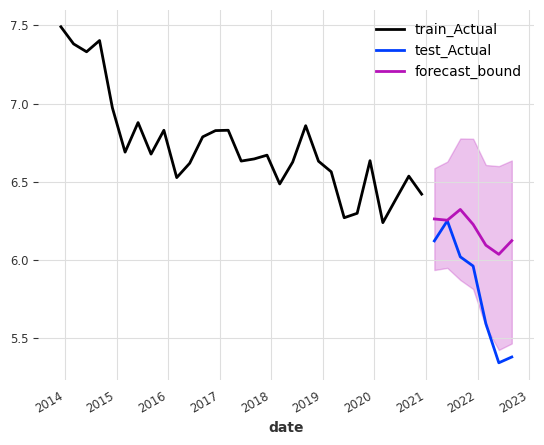

In [36]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train_y)
prediction = model.predict(len(test_y), num_samples=100, verbose=True)
backtest = model.backtest(train_y)
print(backtest)

# plot
train_y.plot(label= 'train_Actual')
test_y.plot(label='test_Actual')
prediction.plot(label="forecast_bound", low_quantile=0.05, high_quantile=0.95)
plt.legend()

# LinearRegression

`enable_optimization=True` is ignored because `retrain` is not `False`To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/19 [00:00<?, ?it/s]

<TimeSeries (DataArray) (date: 4, component: 1, sample: 1)>
array([[[ 0.38470898]],

       [[-0.05781788]],

       [[-0.13225683]],

       [[ 0.02906274]]])
Coordinates:
  * date       (date) datetime64[ns] 2022-12-01 2023-03-01 2023-06-01 2023-09-01
  * component  (component) object 'KV001'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


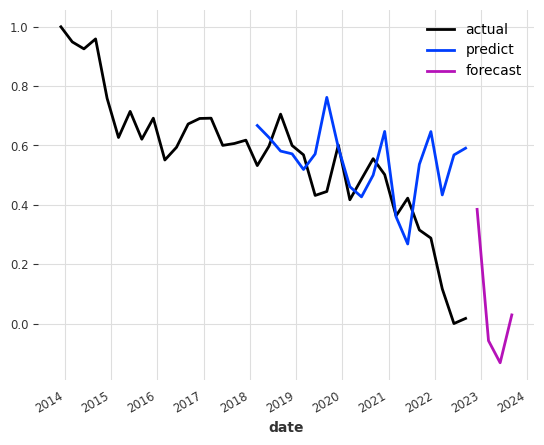

AttributeError: 'RegressionModel' object has no attribute 'keys'

In [78]:
from darts.models import RegressionModel
# from sklearn.linear_model import LinearRegression

# # "KV001"에 대한 TimeSeries 객체 생성
# series_kv001 = TimeSeries.from_dataframe(bank_1, 'date', 'KV001')
# series_past = TimeSeries.from_dataframe(bank_1, 'date', ['KV003','KV004','KV005'])

model_reg = RegressionModel(lags=4,lags_past_covariates=4, output_chunk_length=4)  # lags는 사용할 시간 지연값
# 모델 훈련
model_reg.fit(series_target,past_covariates=series_covar)
# 예측 수행
future = model_reg.predict(n=4, series=series_target,past_covariates=series_covar)  # 다음 5개의 데이터 포인트를 예측
backtest = model_reg.historical_forecasts(
    series_target, past_covariates=series_covar, start=0.4, forecast_horizon=4, verbose=True
)
# 예측 결과 출력
print(future)


## actual VS pred
series_target.plot(label="actual")
# test_y.plot(label="test_actual")
backtest.plot(label="predict")
future.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()


# coefficients = model_reg.model.coef_
# # 특성 중요도 시각화
# plt.barh(features, coefficients)
# plt.xlabel('Coefficient Value')
# plt.ylabel('Feature Name')
# plt.title('Feature Importances')
# plt.show()

from darts.explainability.explainability_result import ComponentBasedExplainabilityResult
explainer = ComponentBasedExplainabilityResult(model_reg)
explain_results = explainer.explain()
output = explain_results.get_explanation(component="some_component")


`enable_optimization=True` is ignored because `retrain` is not `False`To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/19 [00:00<?, ?it/s]

<class 'darts.utils.multioutput.MultiOutputRegressor'>


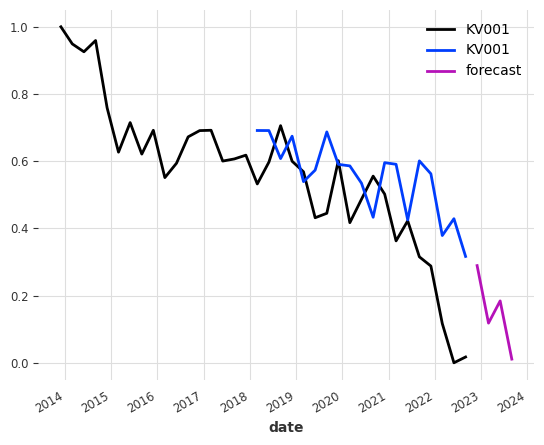

TypeError: Can't instantiate abstract class _ForecastingModelExplainer with abstract methods __init__, explain

In [82]:
from darts.models import XGBModel

model_xgb = XGBModel(lags=4, lags_past_covariates=4, output_chunk_length=4)
model_xgb.fit(series_target,past_covariates=series_covar)
# 예측 수행
future = model_xgb.predict(n=4, verbose=True)  # 다음 5개의 데이터 포인트를 예측
backtest = model_xgb.historical_forecasts(series_target, past_covariates=series_covar, start=0.4, forecast_horizon=4, verbose=True)
# 예측 결과 출력
print(type(model_xgb.model))

# xgb_feature = model_xgb.model.feature_importances_

series_target.plot()
backtest.plot()
future.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

from darts.explainability.explainability import _ForecastingModelExplainer
from darts.explainability import ShapExplainer
# explainer = ShapExplainer(model_xgb)
# explainer.force_plot_from_ts(series_target)
explainer = _ForecastingModelExplainer(model_xgb)
# ComponentBasedExplainabilityResult()
# explainer = ComponentBasedExplainabilityResult(model_xgb)
# explain_results = explainer.explain()
# output = explain_results.get_explanation(component="some_component")

'''explain_results = explainer.explain()
attention = explain_results.get_attention()
importances = explain_results.get_feature_importances()
encoder_importance = explain_results.get_encoder_importance()
decoder_importance = explain_results.get_decoder_importance()
static_covariates_importance = explain_results.get_static_covariates_importance()
print(explain_results)
print(attention)
print(importances)
print(encoder_importance)
print(decoder_importance)
print(decoder_importance)'''

# Transformer Model

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 1.3 K 
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 260   
------------------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.201     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

<TimeSeries (DataArray) (date: 4, component: 1, sample: 1)>
array([[[0.36821   ]],

       [[0.32638854]],

       [[0.24854769]],

       [[0.20111023]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 2022-12-01 2023-03-01 2023-06-01 2023-09-01
  * component  (component) object 'KV001'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


  0%|          | 0/19 [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 1.3 K 
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 260   
------------------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.201     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 1.3 K 
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 260   
------------------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.201     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 1.3 K 
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 260   
------------------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.201     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 1.3 K 
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 260   
------------------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.201     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 1.3 K 
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 260   
------------------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.201     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 1.3 K 
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 260   
------------------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.201     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 1.3 K 
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 260   
------------------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.201     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 1.3 K 
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 260   
------------------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.201     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 1.3 K 
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 260   
------------------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.201     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 1.3 K 
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 260   
------------------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.201     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 1.3 K 
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 260   
------------------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.201     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 1.3 K 
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 260   
------------------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.201     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 1.3 K 
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 260   
------------------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.201     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 1.3 K 
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 260   
------------------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.201     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 1.3 K 
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 260   
------------------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.201     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 1.3 K 
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 260   
------------------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.201     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 1.3 K 
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 260   
------------------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.201     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 1.3 K 
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 260   
------------------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.201     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 1.3 K 
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 260   
------------------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.201     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

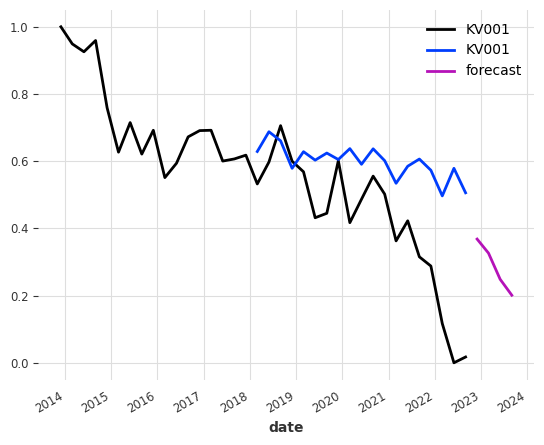

In [70]:
from darts.models import TransformerModel

series_kv001 = series_target.astype("float32")
series_past = series_covar.astype("float32")
model_transformer = TransformerModel(input_chunk_length=4, output_chunk_length=4)
model_transformer.fit(series_kv001,series_past)
pred = model_transformer.predict(n=4)
print(pred)
backtest = model_transformer.historical_forecasts(series_kv001, past_covariates=series_past, start=0.4, forecast_horizon=4, verbose=True)

series_kv001.plot()
backtest.plot()
pred.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

